In [1]:
%reset -f
from helpers import *
%matplotlib inline


Using TensorFlow backend.


# Introduction and Data preprocessing

We entered a colloration with AstraZeneca from June 2016 - December 2016. AstraZeneca conducts internal drug trials to investigate biological targets that are present in disease. The purpose is to search for compounds that modulate these biological targets. This process is known as High Content Screening (HCS).

From a particular High Content Screen conducted last year, the group within AstraZeneca measured the phenotype by taking microscopy images of the assays at intermediate points. They would like to investigate whether machine learning methods, which have broken records in performance computer vision and speech recognition, can identify drugs that would successfully pass later stages of the drug trial, specifically one which passed stage 3, using these intermediate microscopy images.

Stage 1 involved a a basic green fluorescence detection, Stage 2 and 3 involved counter screens, and stage 4 involved extensive laboratory tests. As shown below, approximately 1.7 million potential candidate drugs were included at the start of the trial, ~13000 passed Stage 1, ~3000 passed Stage 2, ~1000 passed Stage 3 and only 30 successfully passed Stage 4.

The task reduces to a binary classification problem, **positive drugs** are drug that pass Stage 3, and **negative drugs** negative drugs are those that do not pass to Stage 3.

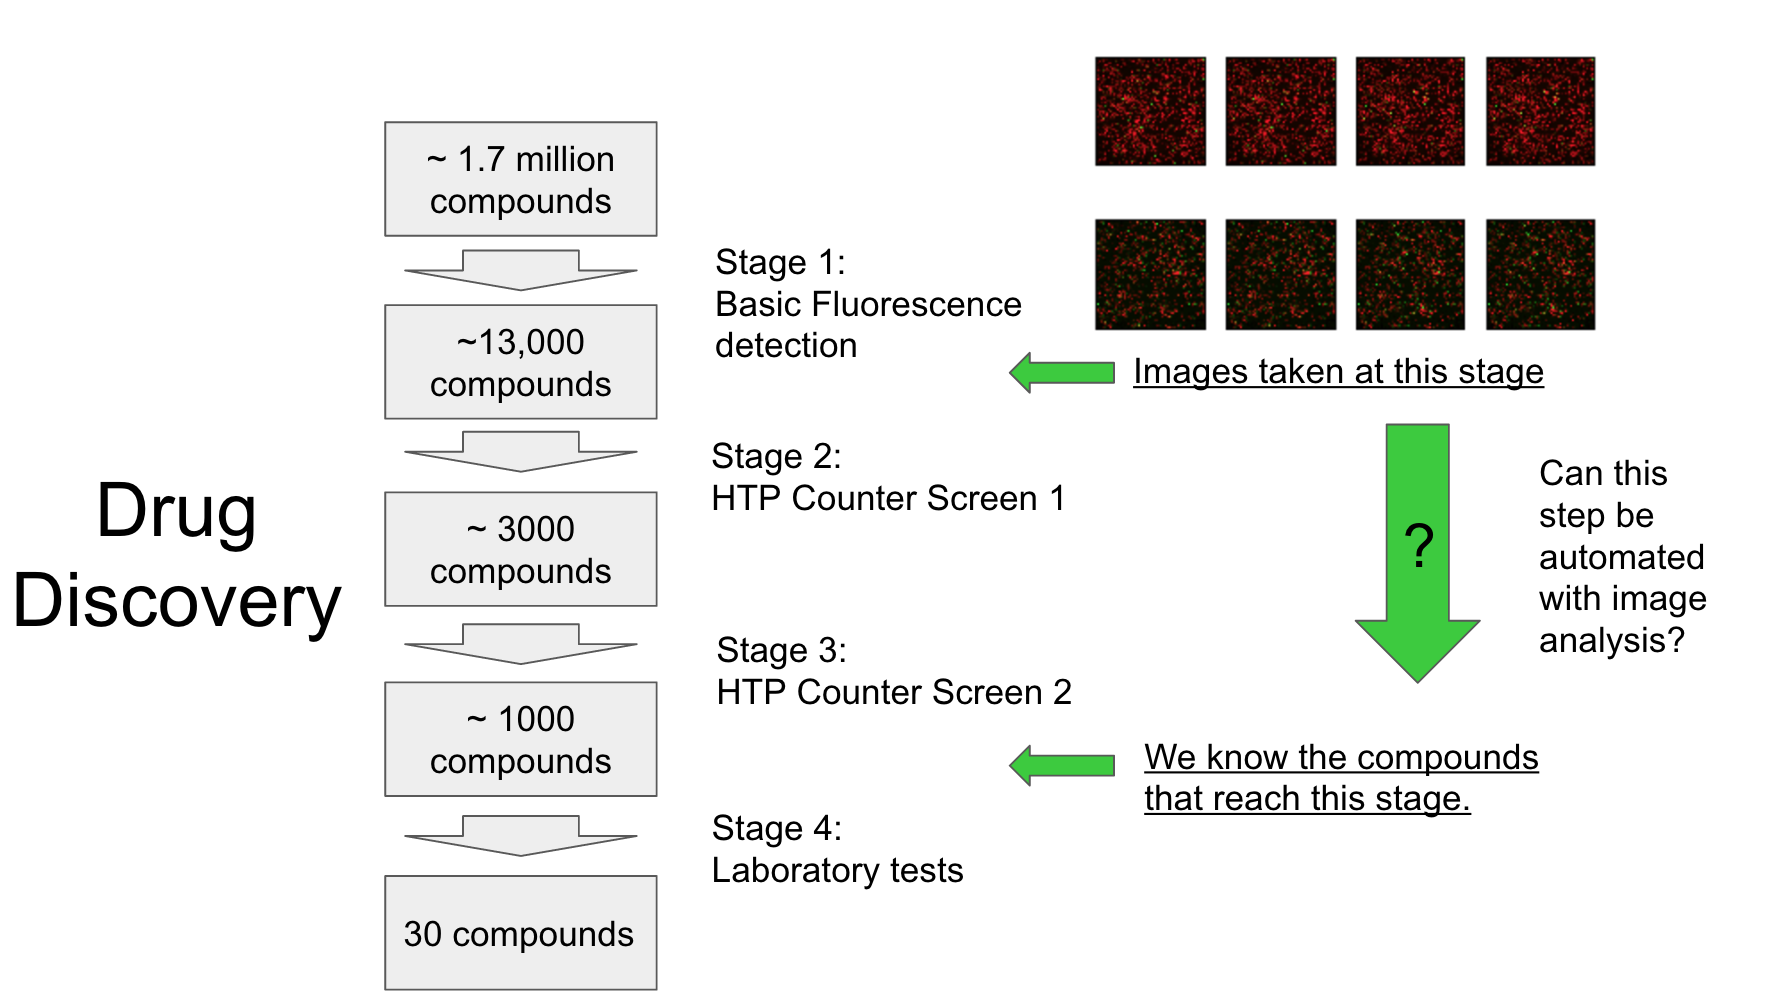

In [3]:
Image(filename='diagrams/DrugTrialflowchart.png') 

In the high content screen, each drug was administered to the cells within a well. 4 images were taken of each well, one for each quadrant, and each image has a red and a green channel. The red channel identifies cell nuclei, and the green channel identifies the GFP tagged antigen. Each well contained a different drug, and so we give each drug an ID which refers to the the plate and well it was located in. In each plate there are many wells each with different well IDs, but across different plates there are wells with the same well ID. Therefore the combination of plate ID and well ID is required to give unique drug IDs. The drug IDs take the form of *plateID*_*wellID*, for example: 1053919905_A07.

We received the microsopy images of this drug trial that were taken after stage 1. We received these images in two batches, called Controls and IXData. The Control images we received on ? and the IXData we received on ?.

In the Control batch, we were given labels for which drug reached stage 3 successfully and which had not. We recieved images for {{len(positive_control_IDs)}} positive drugs and {{len(negative_control_IDs)}} negative drugs.

In the IXData batch, we received clean images for {{len(IXimage_IDs)}} drugs. We also received a list of {{len(IXpositiveIDs)}} positive IDs that successfully passed stage 3. Of this set, there existed images for {{len(valid_positiveIDs)}}. Therefore in total we have 987 positive drugs and 16174 negative drugs



# Control Dataset

## Positive Controls

Displayed below are 3 example images from the positive controls.

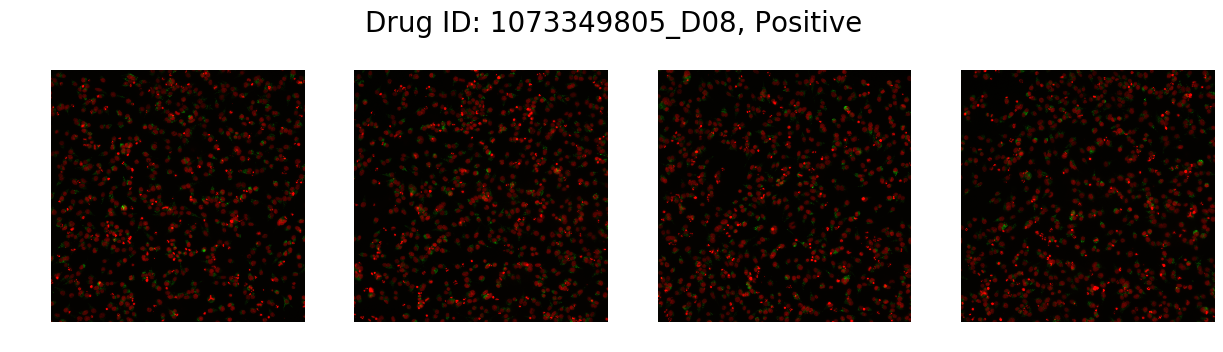

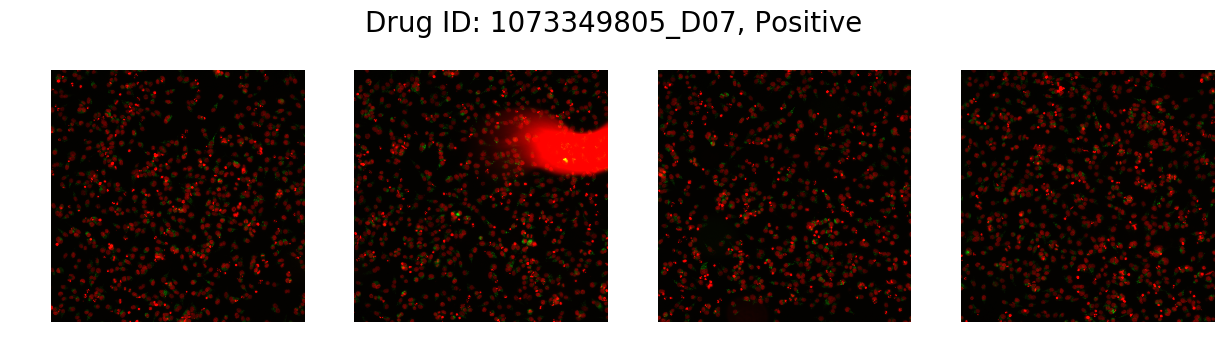

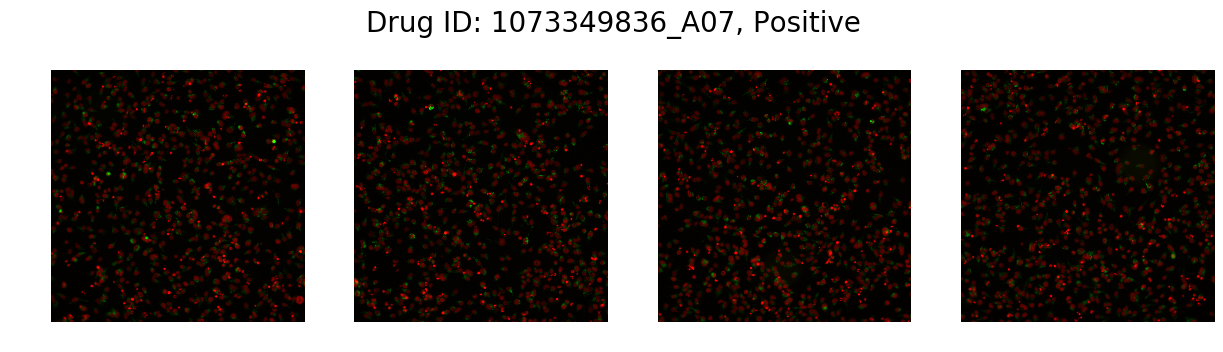

In [359]:
for ID in np.random.choice(positive_control_IDs,3):
    a = Assay(ID, 'processed/CleanPositiveControls/')
    a.display()

## Negative Controls

Below displays 5 example images from the negative controls

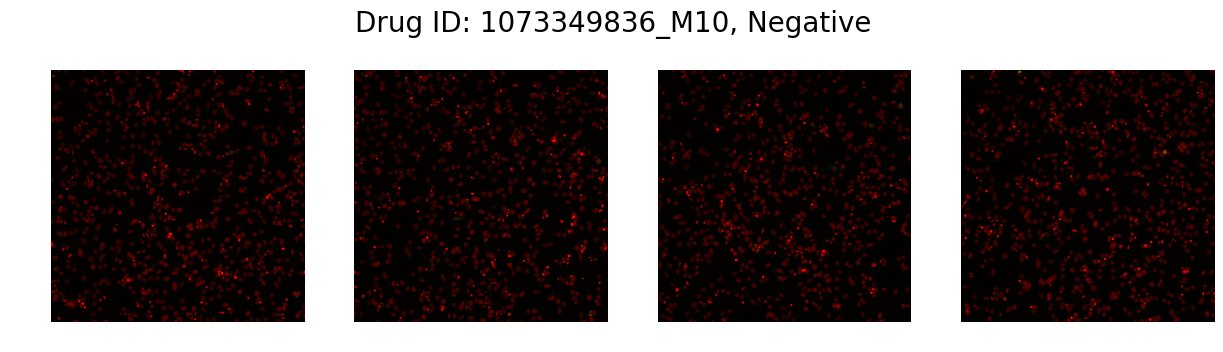

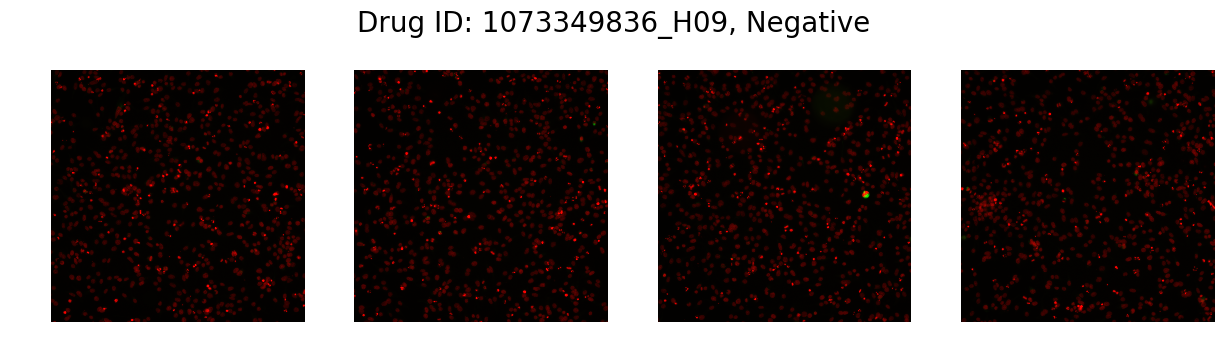

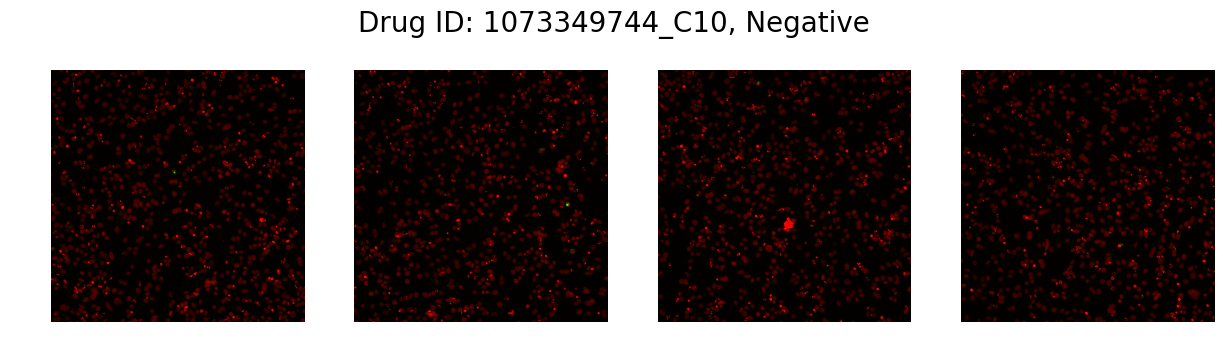

In [360]:
for ID in np.random.choice(negative_control_IDs,3):
    a = Assay(ID, 'processed/CleanNegativeControls/')
    a.display()

# Mean pixel analysis on Control

Presence or absence of green seemed to be a strong indicator of probability of being carried through. To test this we plotted average pixel intensities across 4 replicates.

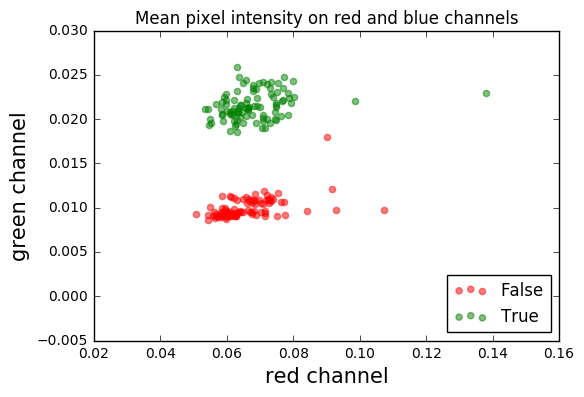

In [361]:
mean_pixel_dict_controls = generate_mean_pixel_intensities_for_controls()
display_pixel_cluster(mean_pixel_dict_controls)

These are clearly seperable. The assays that are carried through tend to have a higher mean pixel intensity on the green channel.

# IXClean

## Positive examples 

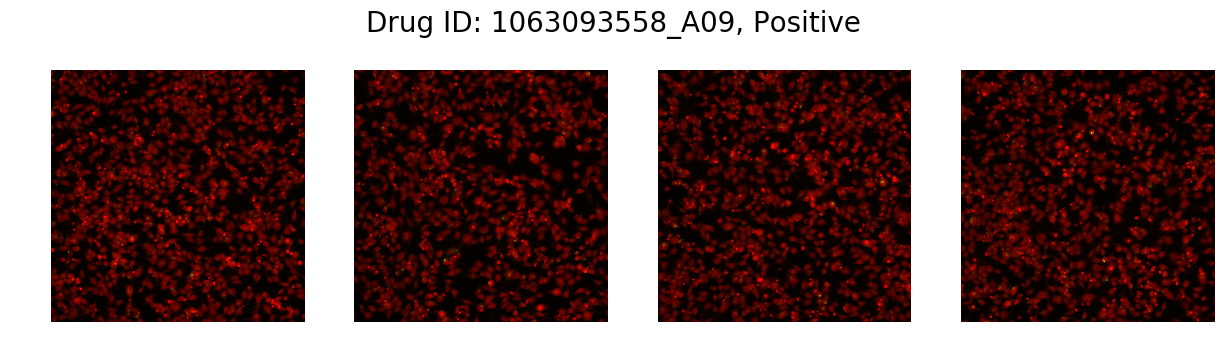

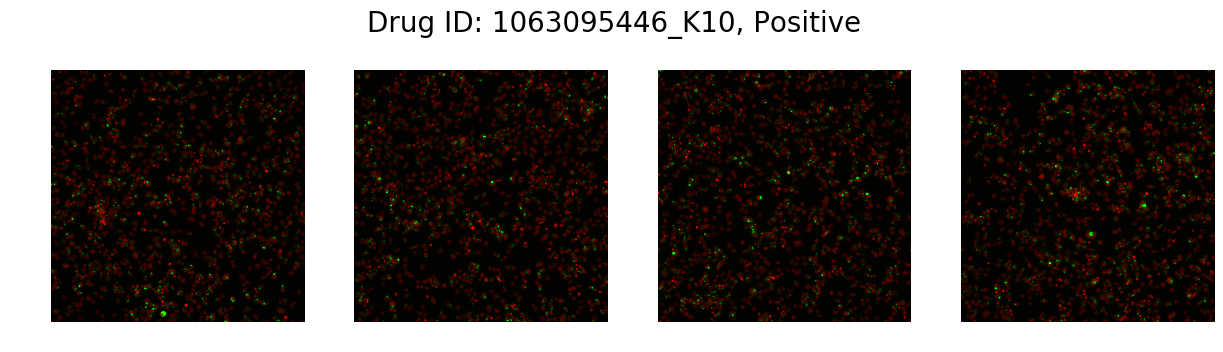

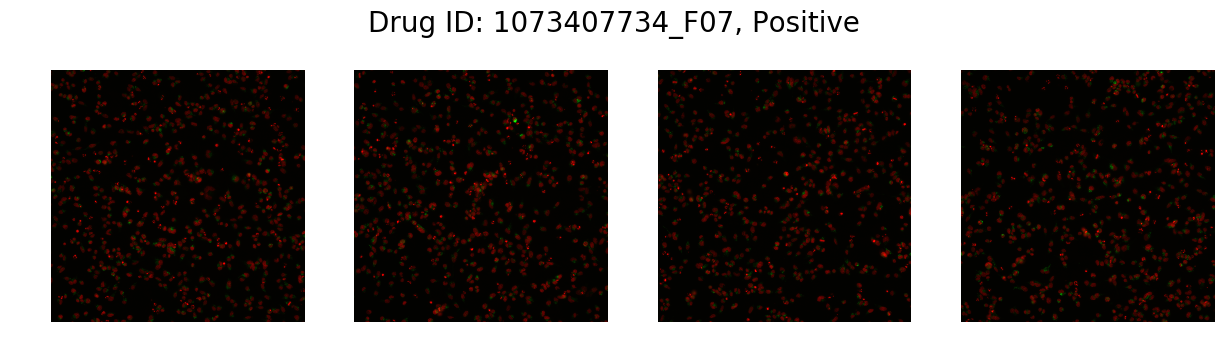

In [87]:
for ID in np.random.choice(IXpositiveIDs,3):
    a = Assay(ID, 'processed/IXClean/')
    a.display()

## Negative examples

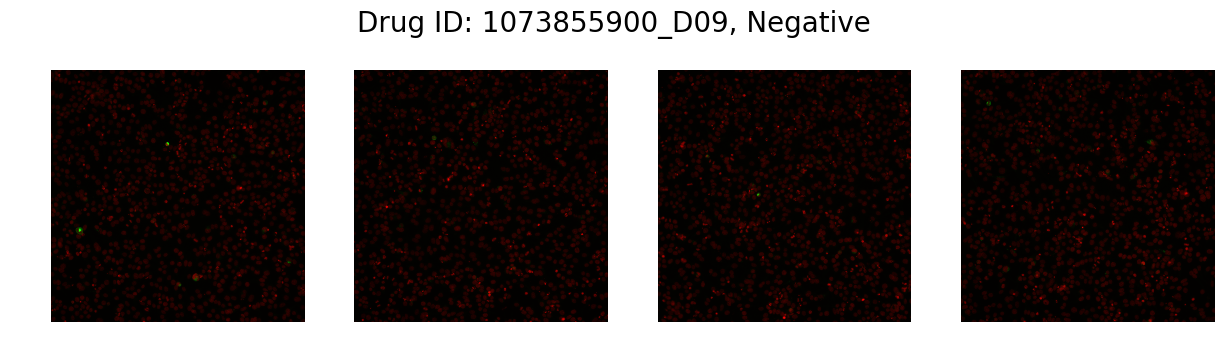

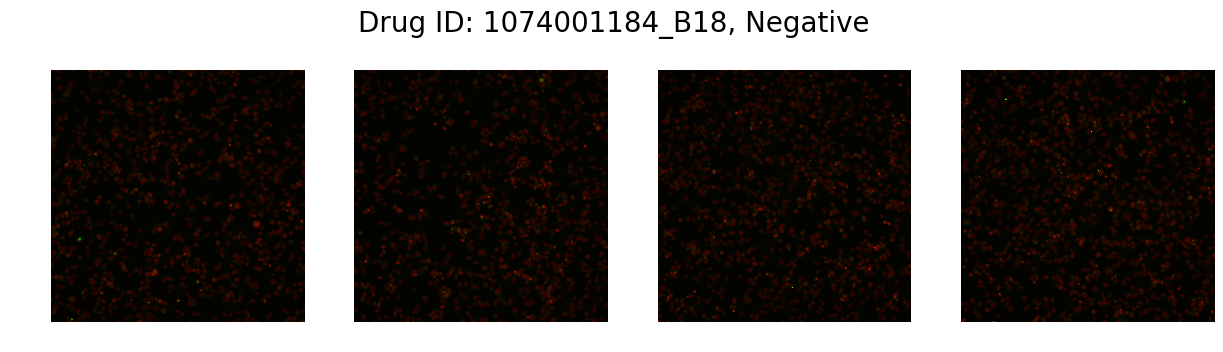

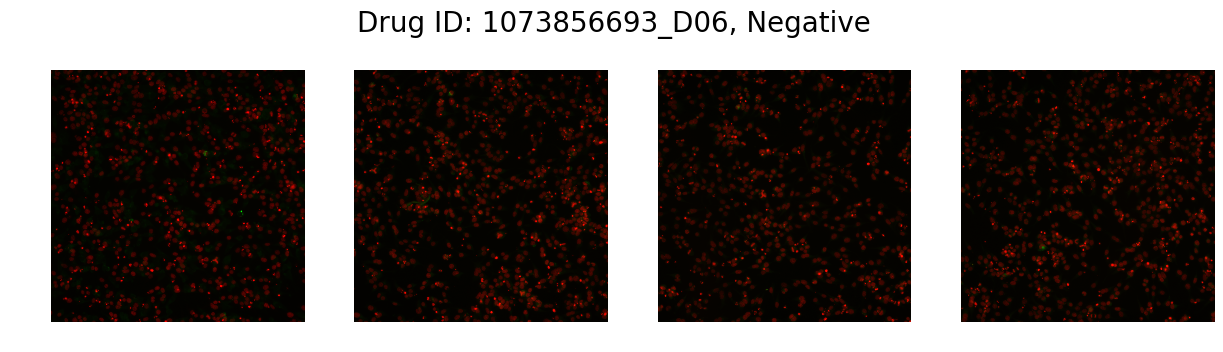

In [88]:
for ID in np.random.choice(IXnegativeIDs,3):
    a = Assay(ID, 'processed/IXClean/')
    a.display()

Just by observing these classes, it is evident that the two classes cannot anymore be differentiate by the mean pixel intensities on the green channel. To confirm this intuition we re-ran the previous pixel intensity analysis.

# Mean pixel analysis on IXClean

Next we tried to see whether the same analysis was able to seperate the classes on the second, larger batch of data.

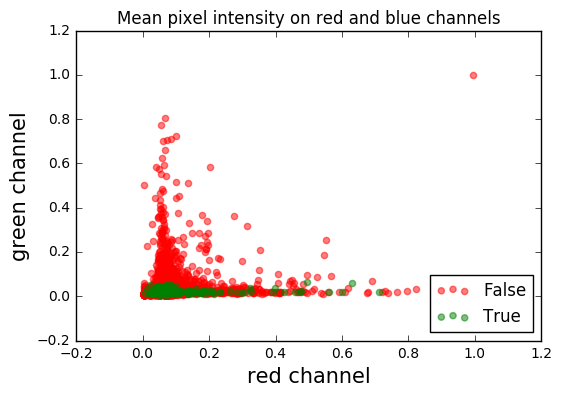

In [89]:
mean_pixel_dict_IXClean = generate_mean_pixel_intensities_for_IXClean()
display_pixel_cluster(mean_pixel_dict_IXClean)

Clearly, in the second batch of data the classes are not seperable. The data seems inconsistent with the first batch, where many pixel intensities in the green channel of the carried through class reached 0.20. In this pixel intensity scatterplot, the drugs there were carried through did not share this characteristic.

# Deep models

I investigated whether the use of deep models could better differentiate these classes. The full images were 2016x2016 pixels, and so were much largertha

## Load the data

In [2]:
data = pickle.load(open('intermediate/training_data_1000.py','rb'))
images, labels = np.array(data[0]), np.array(data[1])
images = np.array([image[100:300,100:300,:] for image in images])
positive_images = np.array(images[labels == True])
positive_labels = np.array(labels[labels == True])
negative_images = np.array(images[labels == False])
negative_labels = np.array(labels[labels == False])

idx = np.random.choice(range(len(negative_images)), len(positive_images))

equalimages = np.vstack([positive_images, negative_images[idx]])
equallabels = np.hstack([positive_labels, negative_labels[idx]])

nb_classes = 2
X_train, X_test, y_train, y_test = train_test_split(equalimages,equallabels, test_size=0.2)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

The images we received were 2016x2016 pixels on 2 channels. For each drug, we take the central square across all 4 quadrants. Therefore we have 4 replicates per drug. We attempt to train a neural network but see that no signal exists. We cannot achieve better the 50% ( guessing by chance ),


## Convolutional Neural Network classifier

### Load model

In [7]:
model = generate_convolutional_model()

### Visualise model

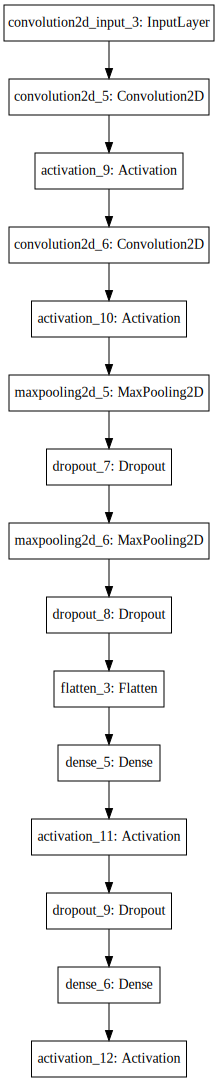

In [12]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Train model

In [10]:
classifier_history = model.fit(X_train, Y_train,
          batch_size=20,
          verbose=0,
          nb_epoch=50,
          validation_data=(X_test, Y_test),
          shuffle=True)

### Show results

Loss seems to steadily decrease, but validation loss increases.

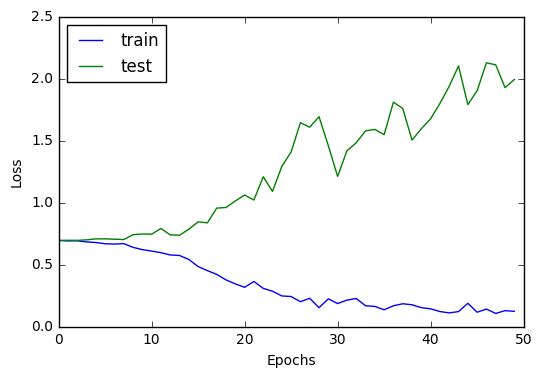

In [43]:
plt.plot(classifier_history.history['loss'], label='train')
plt.plot(classifier_history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

Training accuracy increases but test accuracy does not rise above 0.5.

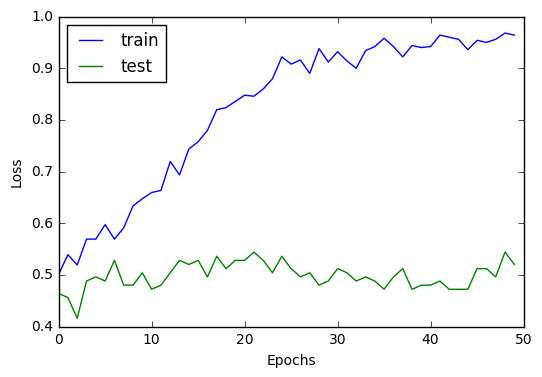

In [44]:
plt.plot(classifier_history.history['acc'], label='train')
plt.plot(classifier_history.history['val_acc'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

## AutoEncoder Analysis

### AutoEncode Red and Green channel

I autoencoded the images with respect to themselves. I used both channels and penalised the green channel 10x as much as the red channel.

In [3]:
autoencoder1 = generate_autoencoder1()

### Train autoencoder

In [4]:
autoencoder_history = autoencoder1.fit(X_train, X_train,
                nb_epoch=50,
                verbose=0,
                batch_size=10,
                shuffle=True,
                validation_data=(X_test, X_test))

### Visualize autoencoder layers

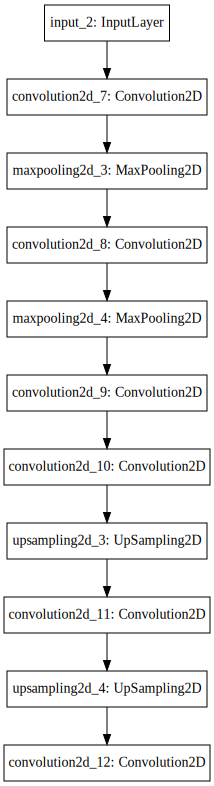

In [11]:
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

### View results

Both training and validation loss decrease nicely

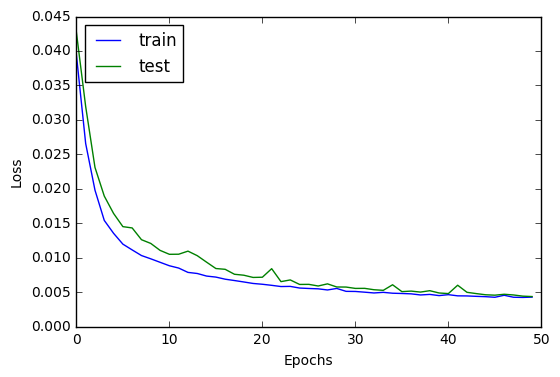

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

### View decodings

The images seem to be well recovered from the encodings on both channels.

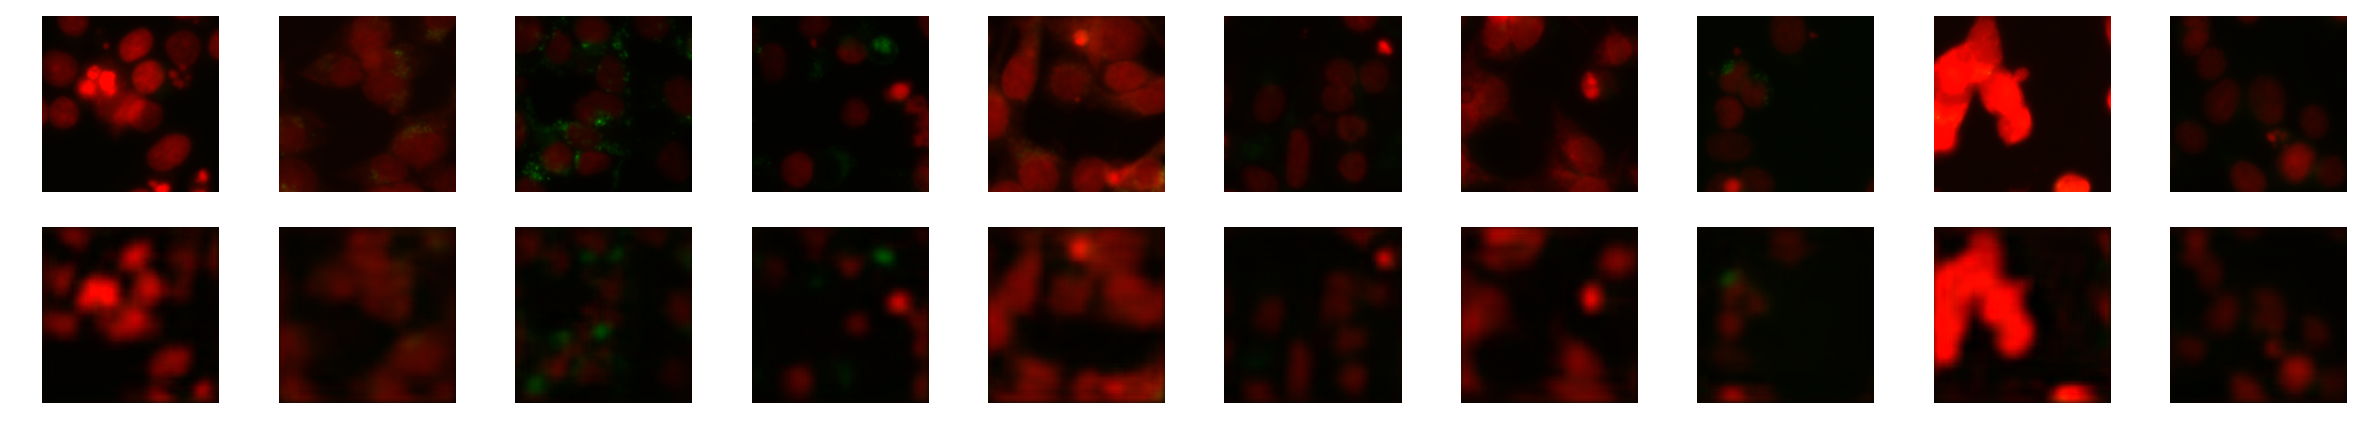

In [9]:
n = 10
idx = np.random.choice(range(len(X_test)), n)
decodings = autoencoder.predict(X_test)
random_images = X_test[idx]
random_decodings = decodings[idx]

f,a = plt.subplots(2,n,figsize=(30,5))
for i in range(n):
    a[0][i].imshow(add_blue(random_images[i]))
    a[0][i].axis('off')
    a[1][i].imshow(multiply_with_overflow(add_blue(random_decodings[i]), factor=[1,1,1]))
    a[1][i].axis('off')

### Investigate inner layers

No obvious features found from the first convolutional layer


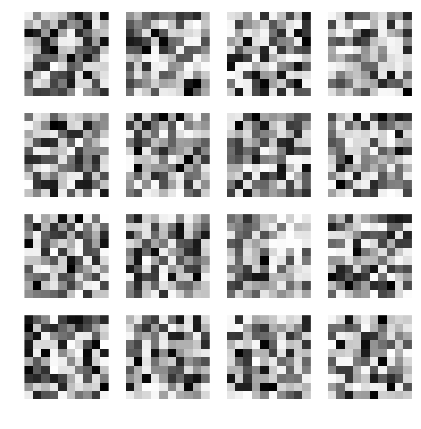

In [150]:
show_mosaic(autoencoder.layers[1].get_weights()[0][:,:,0], figsize=(5,5))

### Comparison with VGG inner layer weights

In [3]:
base_model = VGG19(include_top=True, weights='imagenet', input_tensor=None, input_shape=None)

On an the network pretrained with VGG however, there do seem to exist filters that caputure information.

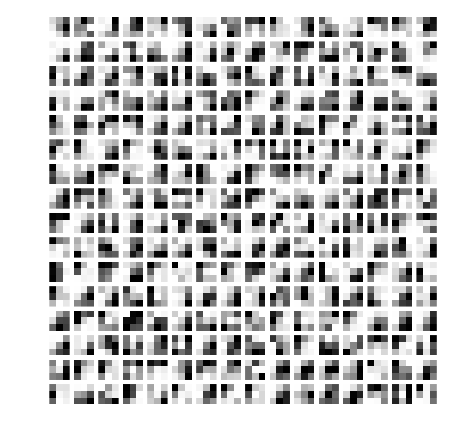

In [23]:
show_mosaic(np.array([base_model.layers[8].get_weights()[0][:,:,0][:,:,i] for i in range(base_model.layers[8].get_weights()[0].shape[-1])]),figsize=(5,5))

### Generate largest activation image VGG

Indeed, when form the image that maximises a given filter, we see that it is able to pick up on textural characteristics of the image.

In [33]:
img_list = generate_maximal_activations(base_model,1)

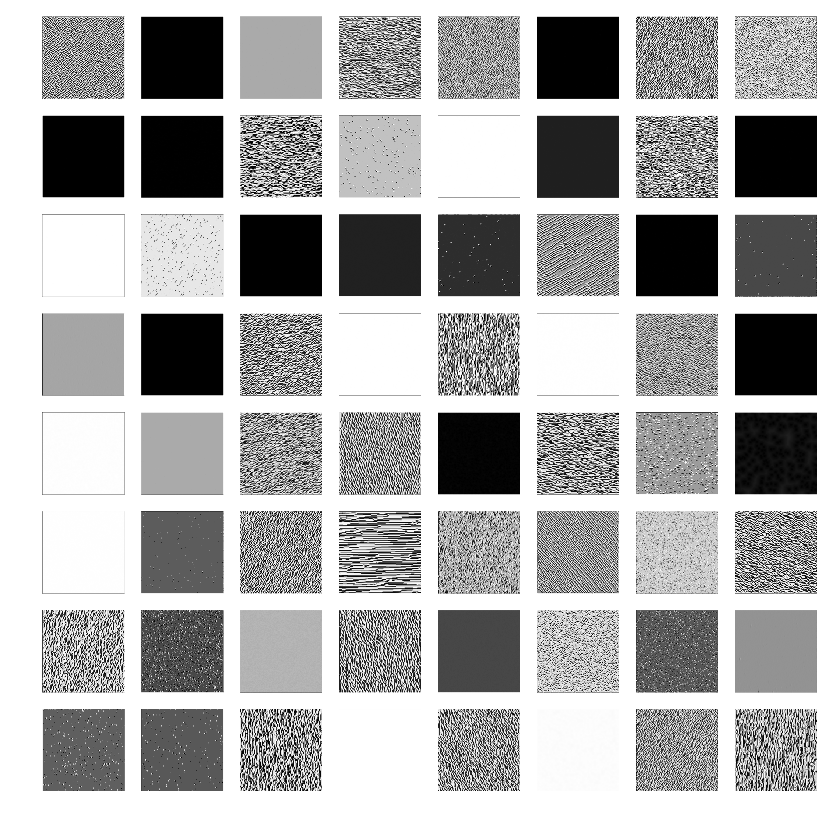

In [34]:
show_mosaic(np.array(img_list), figsize=(10,10))

### Generate layer activation with autoencoder

Textures seem to be picked up using the autoencoder, but do not obviously capture interesting things about the microscopy images.

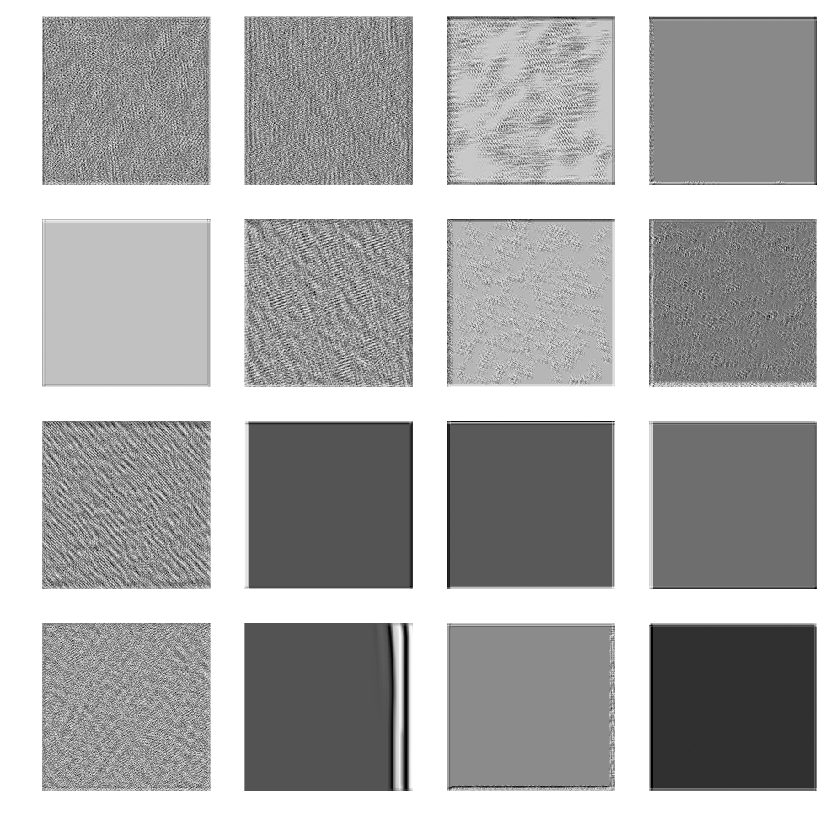

In [274]:
show_mosaic(np.array(img_list), figsize=(10,10))

### Investigate space of encoded output

In [45]:
encodings = encoder.predict(X_train[0:10])

Investigating the space of the encodings, it seems to infact mostly find the identity mapping without any clear features.

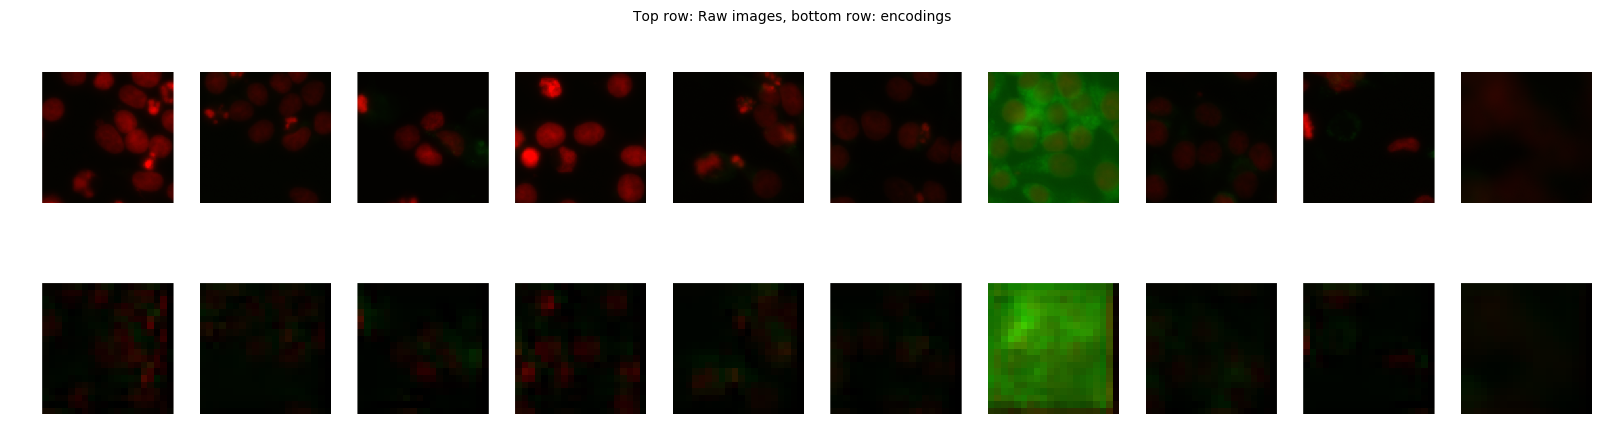

In [86]:
f, a = plt.subplots(2,10, figsize=(20,5))
for i in range(len(encodings)):
    f.suptitle('Top row: Raw images, bottom row: encodings')
    a[0][i].imshow(add_blue(X_train[i]), interpolation='none')
    a[0][i].axis('off')
    a[1][i].imshow(cv2.merge([encodings[i][:,:,1], encodings[i][:,:,0], np.zeros_like(encodings[i][:,:,0])]), interpolation='none')
    a[1][i].axis('off')
    

In [ ]:
sys.path = ['./keras'] + sys.path
from keras.layers import Input, Dense, Convolution2D, Deconvolution2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard
from keras import backend as K
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

def custom_loss(y_true, y_pred):
    red_error = K.mean(K.square(y_pred[:,:,:,0] - y_true[:,:,:,0]), axis=-1)
    green_error = K.mean(K.square(y_pred[:,:,:,1] - y_true[:,:,:,1]), axis=-1)
    return red_error + (10 * green_error)

def add_blue(image):
    return np.stack([image[:,:,0], image[:,:,1], np.zeros_like(image[:,:,1])], axis=2)

## Layers used
e1 = Convolution2D(16, 10, 10, activation='relu', border_mode='same', input_shape=(200,200,2))
e2 = MaxPooling2D((5,5), border_mode='same')
e3 = Convolution2D(8, 5, 5, activation='relu', border_mode='same')
e4 = MaxPooling2D((2,2), border_mode='same')
e5 = Convolution2D(2, 5, 5, activation='relu', border_mode='same')
f = Flatten()
uf = autoencoder.add(Reshape((20,20,2), input_shape=(12,)))
d1 = Convolution2D(16, 5, 5, activation='relu', border_mode='same', )
d2 = UpSampling2D((2,2))
d3 = Convolution2D(8, 5, 5, activation='relu', border_mode='same')
d4 = UpSampling2D((5,5))
d5 = Convolution2D(2, 10, 10, activation='relu', border_mode='same')


autoencoder = Sequential()

autoencoder.add(e1)
autoencoder.add(e2)
autoencoder.add(e3)
autoencoder.add(e4)
autoencoder.add(e5)
model.add(f)

# Model is currently encoded
encoded = autoencoder

# autoencoder.add(d1)
# autoencoder.add(d2)
# autoencoder.add(d3)
# autoencoder.add(d4)
# autoencoder.add(d5)

# # decoder
# decoder_input = Input(shape=(20,20,2))
# d = d1(decoder_input)
# d = d2(d)
# d = d3(d)
# d = d4(d)
# d = d5(d)
# decoder = Model(decoder_input, d)

# # encoder
# encoder_input = input_img
# e = e1(encoder_input)
# e = e2(e)
# e = e3(e)
# e = e4(e)
# e = e5(e)
# encoder = Model(input_img, e)

# autoencoder = Model(input_img, x)
# rmsprop = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
# autoencoder.compile(optimizer=rmsprop, loss=custom_loss)

# layer_dict = dict([(layer.name, layer) for layer in autoencoder.layers])

# Future directions

* To avoid learning the identity maps, the literature recommends using Stacked Denoising Autoencoders, where images are modified such that random noise in introduced. However it is not clear what benefit this would bring. 
* In the classified case, we went straight into building deep models: without ensuring that there was actually signal in the data. Another approach would be to extract features using CellProfiler, and try and train classifiers using purely this information.